# Training Model

In [1]:
from core.networks import AE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

import copy
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
preprocess = {
    "train": transforms.Compose([
        transforms.Resize(64),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
    ]),
    "val": transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
    ])
}

In [3]:
datasets = {
    x: CIFAR10(
        root="./data",
        train = True if x == "train" else False,
        transform = preprocess[x],
    )
    for x in ["train", "val"]
}

In [4]:
datasets["train"]

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-20, 20), resample=False, expand=False)
               ToTensor()
           )

In [5]:
datasets["val"]

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [6]:
dataloaders = {
    x: DataLoader(
        datasets[x],
        batch_size=64,
        shuffle=True,
        num_workers=4
    )
    for x in ["train", "val"]
}

dataset_sizes = {
    x: len(datasets[x])
    for x in ["train", "val"]
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def imshow(inp, title=None):
    """ Imshow for Tensor """
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, cmap=plt.cm.gray)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

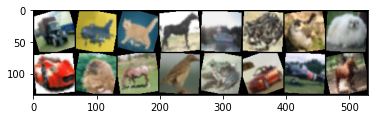

In [8]:
inputs, _ = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(inputs[:16])
imshow(out)

In [9]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    loss_tracker = {
        "train": [],
        "val": [],
    }

    for epoch in range(num_epochs):
        start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, _ in dataloaders[phase]:

                inputs = inputs.to(device)
                # targets = targets.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]

            loss_tracker[phase].append(epoch_loss)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_run_time = time.time() - start
        print(f'epoch running time: {epoch_run_time//60:.03}m {epoch_run_time%60:.03}s')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_tracker

In [10]:
model = AE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [11]:
model, losses = train_model(
    model,
    criterion,
    optimizer,
    num_epochs=10,
)

Epoch 0/9
----------
train Loss: 0.0128
val Loss: 0.0041
epoch running time: 0.0m 49.5s

Epoch 1/9
----------
train Loss: 0.0042
val Loss: 0.0030
epoch running time: 0.0m 48.4s

Epoch 2/9
----------
train Loss: 0.0034
val Loss: 0.0031
epoch running time: 0.0m 48.5s

Epoch 3/9
----------
train Loss: 0.0033
val Loss: 0.0025
epoch running time: 0.0m 48.4s

Epoch 4/9
----------
train Loss: 0.0030
val Loss: 0.0033
epoch running time: 0.0m 48.2s

Epoch 5/9
----------
train Loss: 0.0025
val Loss: 0.0020
epoch running time: 0.0m 48.7s

Epoch 6/9
----------
train Loss: 0.0022
val Loss: 0.0016
epoch running time: 0.0m 48.6s

Epoch 7/9
----------
train Loss: 0.0021
val Loss: 0.0021
epoch running time: 0.0m 48.7s

Epoch 8/9
----------
train Loss: 0.0020
val Loss: 0.0042
epoch running time: 0.0m 48.7s

Epoch 9/9
----------
train Loss: 0.0019
val Loss: 0.0015
epoch running time: 0.0m 48.9s

Training complete in 8m 6s
Best val Loss: 0.001472


In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, target) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)

            outputs = model(inputs)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                imshow(outputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

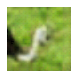

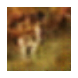

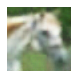

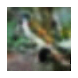

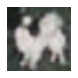

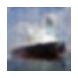

In [13]:
visualize_model(model)